In [1]:
%pylab inline
from tqdm import tqdm
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.callbacks import TensorBoard
import time
import tensorflow as tf
import tensorflow_datasets as tfds

Populating the interactive namespace from numpy and matplotlib


In [2]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [3]:
data = tfds.load('cats_vs_dogs')

In [4]:
datav = data['train'].cache()
test=datav.as_numpy_iterator()
test=[next(test) for i in range(9)]

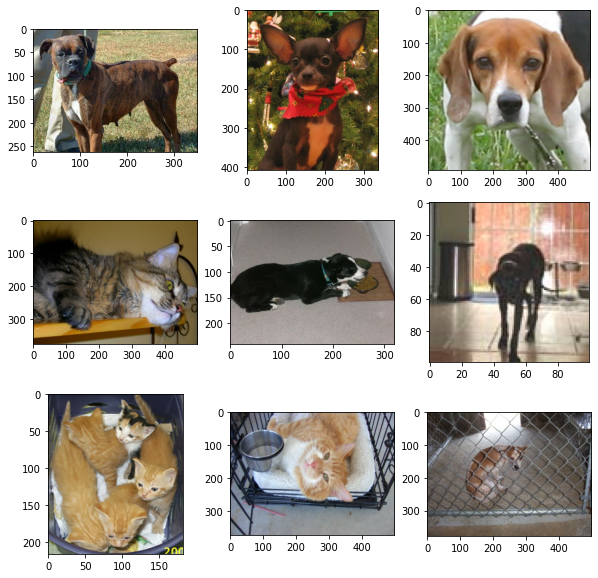

In [5]:
figure(figsize=(10,10))
for i in range(9):
  subplot(3,3,i+1)
  imshow(test[i]['image'])  

In [6]:
def normalize(image,size=200):
  image =  tf.image.rgb_to_grayscale(tf.image.resize(image,size=[size,size]))
  normalized_image = image /255.
  return normalized_image

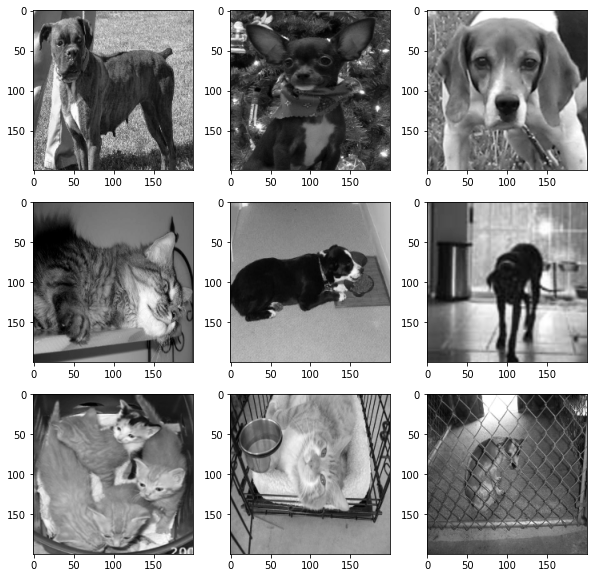

In [7]:
figure(figsize=(10,10))
for i in range(9):
  subplot(3,3,i+1)
  img = normalize(test[i]['image'],200).numpy().reshape(200,200)
  imshow(img,cmap='gray') 

In [8]:
(datat, datav, datas), ds_info = tfds.load('cats_vs_dogs',split=['train[:70%]','train[70%:80%]','train[80%:]'],as_supervised=True,with_info=True)            

In [9]:
def normalize(image,label):
  image =  tf.image.rgb_to_grayscale(tf.image.resize(image,size=[100,100]))
  normalized_image = image /255.
  return normalized_image, label

In [10]:
datat = datat.map(normalize)
datat = datat.cache()
datat = datat.shuffle(ds_info.splits['train'].num_examples)
datat = datat.batch(32)
datat = datat.prefetch(tf.data.experimental.AUTOTUNE)

In [11]:
datav = datav.map(normalize)
datav = datav.cache()
datav = datav.shuffle(ds_info.splits['train'].num_examples)
datav = datav.batch(32)
datav = datav.prefetch(tf.data.experimental.AUTOTUNE)

In [12]:
model = Sequential()

model.add(Conv2D(32, (3, 3)))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Conv2D(32, (3, 3)))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(32))

model.add(Dense(1))
model.add(Activation("sigmoid"))

tensorboard = TensorBoard(log_dir="logs/{}".format(time.time()))


model.compile(loss="binary_crossentropy",
              optimizer="adam",
              metrics=['accuracy'],
              )

model.fit(datat,
          epochs=40,
          validation_data=datav,
          callbacks=[tensorboard])
model.save('first.model')


Epoch 1/40
509/509 [==============================] - 88s 106ms/step - loss: 0.6999 - accuracy: 0.6054 - val_loss: 0.6271 - val_accuracy: 0.6627
Epoch 2/40
509/509 [==============================] - 51s 99ms/step - loss: 0.5702 - accuracy: 0.7090 - val_loss: 0.5636 - val_accuracy: 0.7134
Epoch 3/40
509/509 [==============================] - 51s 99ms/step - loss: 0.4994 - accuracy: 0.7588 - val_loss: 0.5200 - val_accuracy: 0.7495
Epoch 4/40
509/509 [==============================] - 51s 100ms/step - loss: 0.4520 - accuracy: 0.7901 - val_loss: 0.5708 - val_accuracy: 0.7177
Epoch 5/40
509/509 [==============================] - 50s 99ms/step - loss: 0.4019 - accuracy: 0.8161 - val_loss: 0.5173 - val_accuracy: 0.7615
Epoch 6/40
509/509 [==============================] - 51s 99ms/step - loss: 0.3505 - accuracy: 0.8497 - val_loss: 0.5511 - val_accuracy: 0.7555
Epoch 7/40
509/509 [==============================] - 50s 99ms/step - loss: 0.3000 - accuracy: 0.8718 - val_loss: 0.5537 - val_accurac

INFO:tensorflow:Assets written to: first.model/assets


In [13]:
datas = datas.map(normalize)

In [14]:
datas = datas.batch(1)

In [15]:
predictions=np.round(model.predict(datas))

In [16]:
datait = datas.as_numpy_iterator()
datas_list = [next(datait) for i in range(datas.cardinality().numpy()) ]

In [17]:
predictions.shape

(4652, 1)

In [18]:
truths = np.array([datas_list[i][1] for i in range(datas.cardinality().numpy()) ])

In [19]:
sum(truths == predictions)/len(predictions)

0.7377472055030094

In [20]:
(_ , _, data_test_visual), _ = tfds.load('cats_vs_dogs',split=['train[:70%]','train[70%:80%]','train[80%:]'],as_supervised=True,with_info=True) 

data_test_visual_it = data_test_visual.as_numpy_iterator()
data_test= np.array([next(data_test_visual_it) for i in range(data_test_visual.cardinality().numpy()) ])

  

<ipython-input-20-13a9471189a3>:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  data_test= np.array([next(data_test_visual_it) for i in range(data_test_visual.cardinality().numpy()) ])


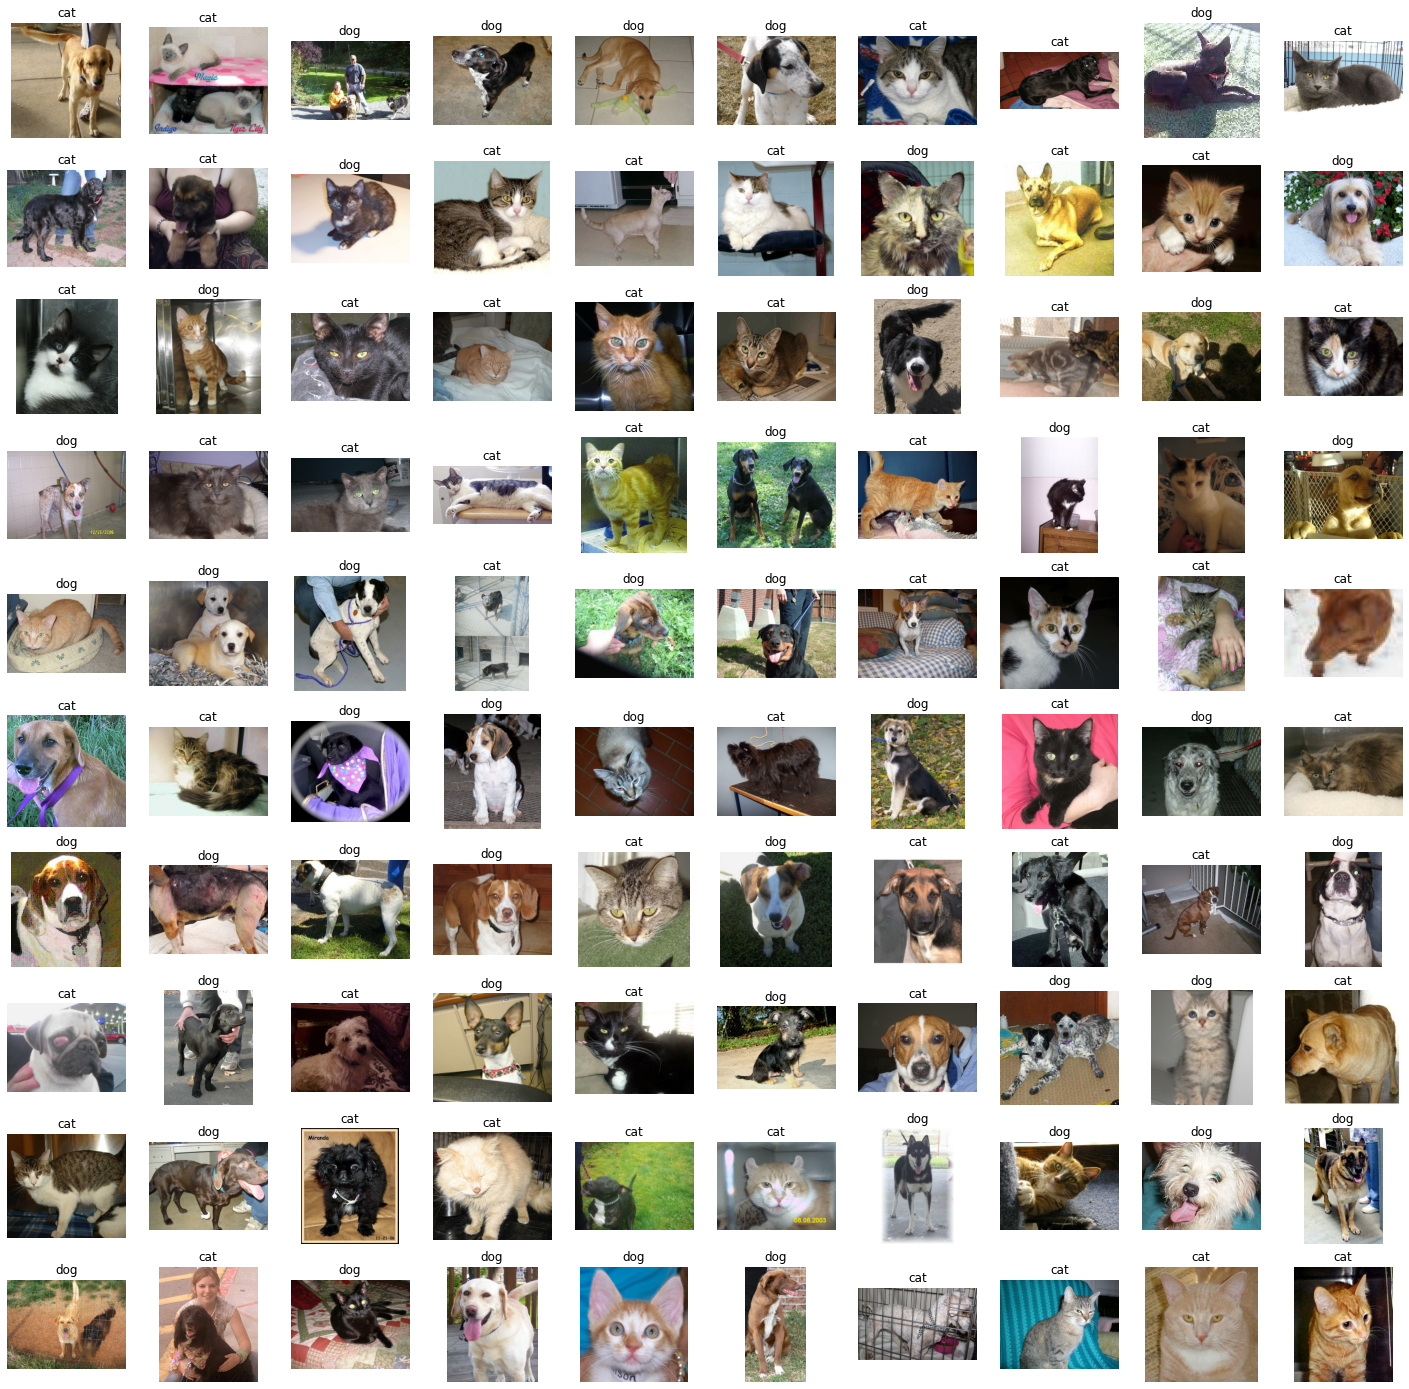

In [21]:
figure(figsize=(25,25))
for i in range(100):
  subplot(10,10,i+1)
  imshow(data_test[i][0])
  if predictions[i]<.5:
    label = "cat"
  else:
    label = "dog"
  title(label)
  axis('off')